https://www.youtube.com/watch?v=C--57BP79EM

In [0]:
import bs4 as bs
import pickle
import requests
import datetime as dt
import os
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np

style.use('ggplot')

In [0]:
#https://en.wikipedia.org/wiki/List_of_S%26P_500_companies
def save_sp500_tickers():
    resp=requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup=bs.BeautifulSoup(resp.text,'lxml')
    #select the table that have you data
    table=soup.find('table',{'class':'wikitable sortable'})
    tickers=[]
    for row in table.findAll('tr')[1:]:
        ticker=row.findAll('td')[0].text
        tickers.append(ticker.rstrip())#rstrip() remove the \n that comes together
    
    with open('/content/SP500/sp500tickers.pickle','wb') as f:
        pickle.dump(tickers,f)
    
    #print(tickers)
    return tickers
    

In [0]:
#save_sp500_tickers()
#import os
#os.mkdir('/content/SP500/')

In [0]:
# date from yahoo
#https://www.youtube.com/watch?v=baCAFPHb1o4
def get_data_from_yahoo(reload_sp500=False):
    if reload_sp500:
        tickers=save_sp500_tickers()
    else:
        with open('/content/SP500/sp500tickers.pickle','rb') as f:
            tickers=pickle.load(f)
    
    if not os.path.exists('/content/SP500/stock_dfs'):
        os.makedirs('/content/SP500/stock_dfs')
    
    start = dt.datetime(2000,1,1)
    end = dt.datetime(2019,6,19)
    
    for ticker in tickers:#tickers[:25]: apenas as 25 primeiras
        print(ticker)
        try:
            if not os.path.exists('/content/SP500/stock_dfs/{}.csv'.format(ticker)):
                df=web.DataReader(ticker,'yahoo',start,end)
                df.to_csv('/content/SP500/stock_dfs/{}.csv'.format(ticker))
            else:
                print('Already have {}'.format(ticker))
        except Exception as error:
            print(error)
            
    

In [0]:
#get_data_from_yahoo()


In [0]:
#juntas todas as stocks em um arquivo apenas
def compile_data():
    with open('/content/SP500/sp500tickers.pickle','rb') as f:
        tickers=pickle.load(f)
    
    main_df=pd.DataFrame()
    
    for count,ticker in enumerate(tickers):
        try:
            df=pd.read_csv('/content/SP500/stock_dfs/{}.csv'.format(ticker))
            df.set_index('Date',inplace=True)

            df.rename(columns={'Adj Close': ticker}, inplace=True)
            df.drop(['Open','High','Low','Close','Volume'],1,inplace=True)

            if main_df.empty:
                main_df=df
            else:
                main_df=main_df.join(df,how='outer')

            if count%50==0:
                print(count)
        except:
            pass
    print(main_df.head())
    main_df.to_csv('/content/SP500/sp500_joined_closes.csv')    
        

In [13]:
compile_data()

0
50
100
150
200
250
300
350
400
450
500
                  MMM       ABT  ABBV      ABMD  ...       YUM  ZBH       ZION  ZTS
Date                                             ...                               
2000-01-03  27.060949  6.671639   NaN  18.25000  ...  4.457160  NaN  42.207615  NaN
2000-01-04  25.985683  6.481020   NaN  17.81250  ...  4.367568  NaN  40.163754  NaN
2000-01-05  26.738375  6.469106   NaN  18.00000  ...  4.389968  NaN  40.116234  NaN
2000-01-06  28.888908  6.695467   NaN  18.03125  ...  4.352638  NaN  40.686600  NaN
2000-01-07  29.462400  6.766949   NaN  17.93750  ...  4.255581  NaN  40.781673  NaN

[5 rows x 503 columns]


In [0]:
def visualize_data():
    df=pd.read_csv('/content/SP500/sp500_joined_closes.csv') 
    #df['AAPL'].plot()
    df_corr=df.corr()
    #print(df_corr.head())
    data=df_corr.values
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    
    heatmap=ax.pcolor(data,cmap=plt.cm.RdYlGn)
    fig.colorbar(heatmap)
    ax.set_xticks(np.arange(data.shape[0])+0.5, minor=False)
    ax.set_yticks(np.arange(data.shape[1])+0.5, minor=False)
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    
    column_labels=df_corr.columns
    row_labels=df_corr.index
    
    ax.set_xticklabels(column_labels)
    ax.set_yticklabels(column_labels)
    plt.xticks(rotation=90)
    heatmap.set_clim(-1,1)
    
    plt.tight_layout()
    

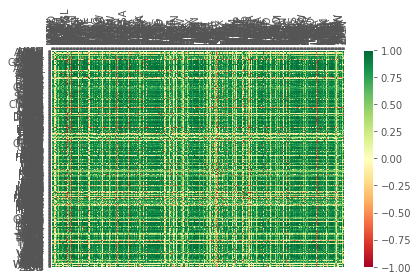

In [15]:
visualize_data()